In [7]:
import genomeview
import pyBigWig
import subprocess, os, glob


from IPython.display import display, HTML

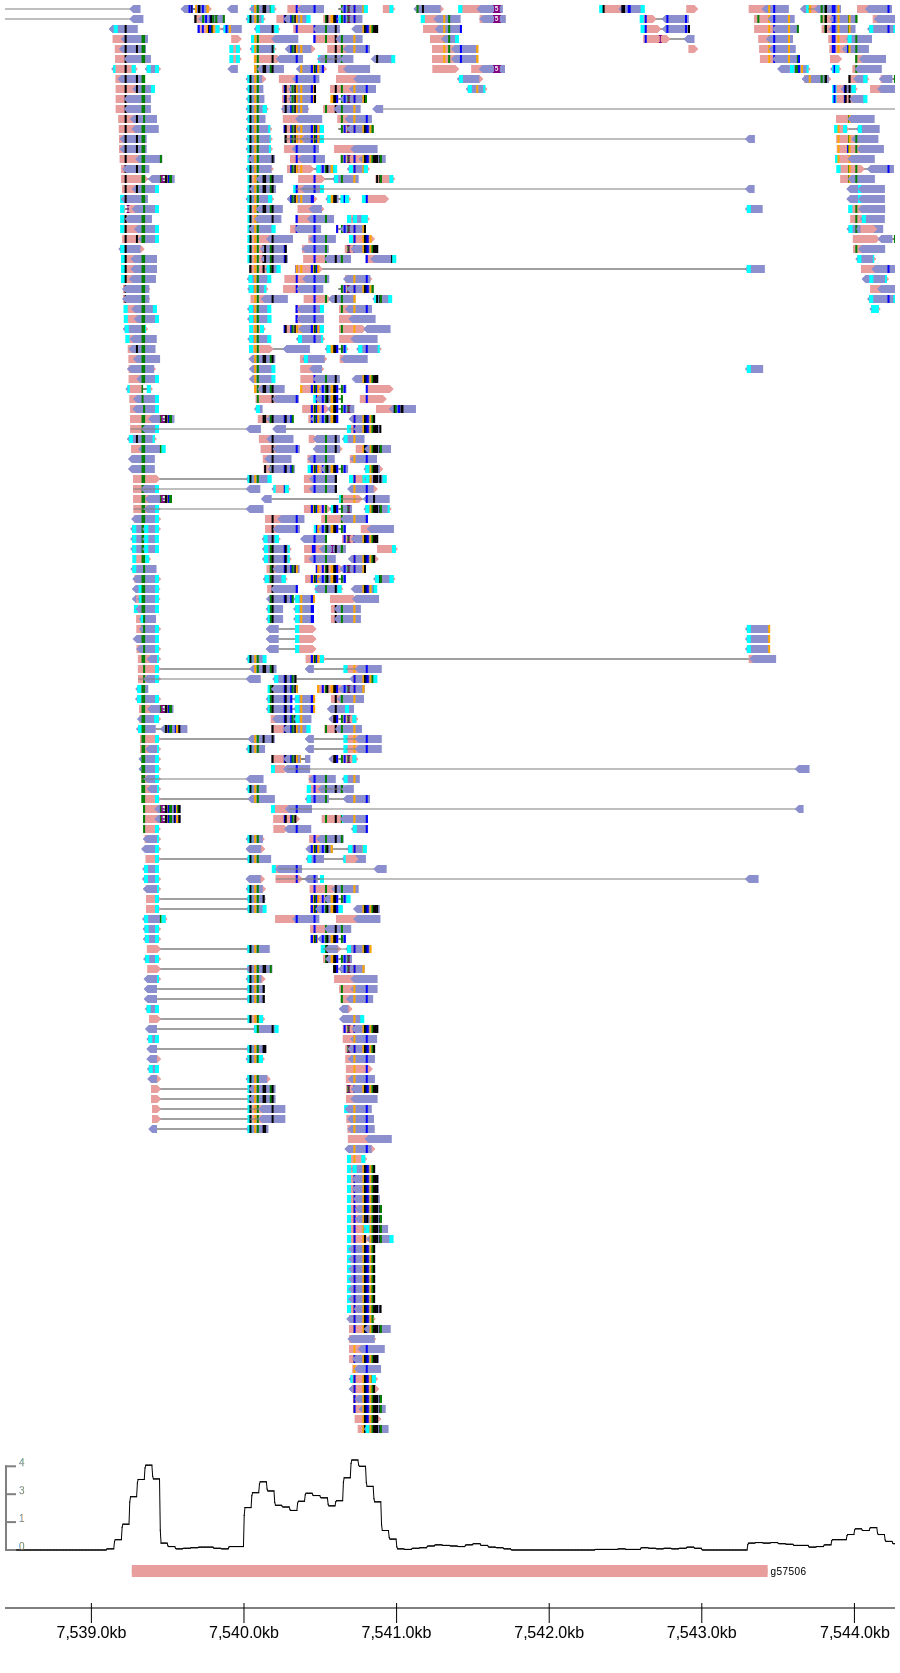

In [4]:
sample_index = 77
fasta_path = '/home/daniel_le/data/botryllus/genome/botznik-chr.fa'
genebed_path = '/home/daniel_le/data/botryllus/genome/botznik-chr-all.bed'
bam_path = f'/home/daniel_le/data/botryllus/results/sample_{sample_index}.sorted.bam'
bw_path = f'/home/daniel_le/data/botryllus/coverage/sample_{sample_index}.bw'
n_threads = 16

#bamCoverage -p n_threads -b a.bam -o a.bw
if not os.path.exists(bw_path):
    subprocess.call([
                    'bamCoverage',
                    '-p',
                    str(n_threads),
                    '-b',
                    bam_path,
                    '-o',
                    bw_path,
                    ])

dataset_paths = [
                 bam_path,
                 bw_path,
                 genebed_path,
                ]

# BHF = chr9:7538434..7544266
chrom = "chr9"
start = 7538434
end =   7544266

doc = genomeview.visualize_data(dataset_paths, chrom, start, end, fasta_path)
doc


In [12]:
fasta_path = '/home/daniel_le/data/botryllus/genome/botznik-chr.fa'
genebed_path = '/home/daniel_le/data/botryllus/genome/botznik-chr-all.bed'
n_threads = 16


for bambai_path in glob.glob(f'/home/daniel_le/data/botryllus/results/*.sorted.bam.bai'):
    try:
        print(bambai_path)
        dataset_paths = [genebed_path]
        sample_index = bambai_path.split('/sample_')[-1].split('.sorted.bam.bai')[0]
        bw_path = f'/home/daniel_le/data/botryllus/coverage/sample_{sample_index}.bw'
        bam_path = f'/home/daniel_le/data/botryllus/results/sample_{sample_index}.sorted.bam'
        if not os.path.exists(bw_path):
            print('creating:', bw_path)
            subprocess.call([
                            'bamCoverage',
                            '-p',
                            str(n_threads),
                            '--normalizeUsing',
                            'CPM',
                            '--ignoreDuplicates',
                            '-b',
                            bam_path,
                            '-o',
                            bw_path,
                            ])
#         dataset_paths = dataset_paths+[bw_path]

#         # BHF = chr9:7538434..7544266
#         chrom = "chr9"
#         start = 7538434
#         end =   7544266

#         doc = genomeview.visualize_data(dataset_paths, chrom, start, end, fasta_path)
#         display(doc)
    except:
        pass
    

/home/daniel_le/data/botryllus/results/sample_80.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_69.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_11.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_33.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_95.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_84.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_8.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_27.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_85.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_43.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_7.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_3.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_59.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_1.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample_5.sorted.bam.bai
/home/daniel_le/data/botryllus/results/sample